## 모듈 import

In [1]:
#모듈 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pycaret.classification  import *

# feature selection
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

# permutation importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5 
from eli5.sklearn import PermutationImportance

#Scailing
from sklearn.preprocessing import PowerTransformer

#Label Encoding
from sklearn.preprocessing import LabelEncoder

# 상관관계 시각화
#matplotlib 한글깨짐 지원
import platform
from matplotlib import font_manager, rc
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  
import seaborn as sns #EDA

In [2]:
#삡운드
import winsound as sd
# 삡싸운드
def beepsound():
    fr = 2000   # range : 37 ~ 32767
    du = 1000 # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)

## data 불러오기

In [3]:
# 데이터가 저장된 경로 설정
data_path = '../data/'

# 데이터 불러오기
train = pd.read_csv(data_path + 'train_df.csv', encoding='cp949')
test = pd.read_csv(data_path + 'test_df.csv', encoding='cp949')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [4]:
train

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9
3,3,1154500002014200,5011000315087400,식품,농산물,10
4,4,1165000021008300,5011000177051200,식품,가공식품,3
...,...,...,...,...,...,...
31995,31995,5011001060063300,2635000026053400,식품,농산물,6
31996,31996,5011001095042400,1168000017002200,식품,기타식품,5
31997,31997,5011001108036200,4119700008012100,식품,농산물,9
31998,31998,5011001115011400,1132000015085100,식품,농산물,3


### 전처리

In [5]:
data = pd.concat([train,test]).reset_index(drop=True);data

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3.0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3.0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9.0
3,3,1154500002014200,5011000315087400,식품,농산물,10.0
4,4,1165000021008300,5011000177051200,식품,가공식품,3.0
...,...,...,...,...,...,...
36635,36635,5013000858004400,4725000719072200,식품,농산물,NaN
36636,36636,5013000870018300,2826000106075300,식품,농산물,NaN
36637,36637,5013000897086300,4311100034004300,식품,농산물,NaN
36638,36638,5013000902065100,4145000013011200,식품,농산물,NaN


- Make Feature

In [6]:
# 송하인 기준으로 총 몇개의 택배를 보냈는지 확인하여 이를 피처로 만들어줌 
groupby_SEND_SPG_INNB_sum = data.groupby('SEND_SPG_INNB').sum()['INVC_CONT'].reset_index()
# 이후에 피처로 만들어주기 위한 dic생성
groupby_SEND_SPG_INNB_sum_dix = {x:y for x,y in zip(groupby_SEND_SPG_INNB_sum['SEND_SPG_INNB'], groupby_SEND_SPG_INNB_sum['INVC_CONT'])}
# 피처 생성
data['총물류량_송하인'] = data['SEND_SPG_INNB'].apply(lambda x: groupby_SEND_SPG_INNB_sum_dix[x])

In [7]:
# 송하인 기준으로 총 몇명의 수하인에게 택배를 보냈는지 확인하여 이를 피처로 만들어줌 
groupby_SEND_SPG_INNB_count = data.groupby('SEND_SPG_INNB').count()['REC_SPG_INNB'].reset_index()
# 이후에 피처로 만들어주기 위한 dic생성
groupby_SEND_SPG_INNB_count_dix = {x:y for x,y in zip(groupby_SEND_SPG_INNB_count['SEND_SPG_INNB'], groupby_SEND_SPG_INNB_count['REC_SPG_INNB'])}
# 피처 생성
data['거래수하인수'] = data['SEND_SPG_INNB'].apply(lambda x: groupby_SEND_SPG_INNB_count_dix[x])

In [8]:
# 평균 한건당 몇번의 수화물을 보내는지에 대한 피처 생성
data['평균거래량_송하인'] = data['총물류량_송하인'] / data['거래수하인수']

In [9]:
# 수하인 기준으로 총 몇개의 택배를 보냈는지 확인하여 이를 피처로 만들어줌 
groupby_REC_SPG_INNB_sum = data.groupby('REC_SPG_INNB').sum()['INVC_CONT'].reset_index()
# 이후에 피처로 만들어주기 위한 dic생성
groupby_REC_SPG_INNB_sum_dix = {x:y for x,y in zip(groupby_REC_SPG_INNB_sum['REC_SPG_INNB'], groupby_REC_SPG_INNB_sum['INVC_CONT'])}
# 피처 생성
data['총물류량_수하인'] = data['REC_SPG_INNB'].apply(lambda x: groupby_REC_SPG_INNB_sum_dix[x])

In [10]:
# 수하인 기준으로 총 몇명의 송하인에게 택배를 받았는지 확인하여 이를 피처로 만들어줌 
groupby_REC_SPG_INNB_count = data.groupby('REC_SPG_INNB').count()['SEND_SPG_INNB'].reset_index()
# 이후에 피처로 만들어주기 위한 dic생성
groupby_REC_SPG_INNB_count_dix = {x:y for x,y in zip(groupby_REC_SPG_INNB_count['REC_SPG_INNB'], groupby_REC_SPG_INNB_count['REC_SPG_INNB'])}
# 피처 생성
data['거래송하인수'] = data['REC_SPG_INNB'].apply(lambda x: groupby_REC_SPG_INNB_count_dix[x])

In [11]:
# 평균 한건당 몇번의 수화물을 보내는지에 대한 피처 생성
data['평균거래량_수하인'] = data['총물류량_수하인'] / data['거래송하인수']

In [12]:
# dic_max = {x: y for x, y in zip(data.groupby('SEND_SPG_INNB').max()[['DL_GD_LCLS_NM', '거래수하인수']].query('거래수하인수 > 100').reset_index()['SEND_SPG_INNB'], 
#                      data.groupby('SEND_SPG_INNB').max()[['DL_GD_LCLS_NM', '거래수하인수']].query('거래수하인수 > 100').reset_index()['DL_GD_LCLS_NM'])}
# data['최대거래품목'] = data['SEND_SPG_INNB'].apply(lambda x: dic_max[x] if x in dic_max else '거래량적음')

In [13]:
# # 상관관계가 높아서 제거
# data =  data.drop('거래수하인수', axis=1)

In [14]:
# 인코딩과 스케일링을 위함
data_index = data['index']
y_data = data['INVC_CONT']

data = data.drop(columns=['index', 'INVC_CONT'])

- 결측치 채움 -> 없음

- Encoding, Scailing

In [15]:
# # 수동으로 범주형 변수로 만들어줌
# data['SEND_SPG_INNB'] = data['SEND_SPG_INNB'].astype('str')
# data['REC_SPG_INNB'] = data['REC_SPG_INNB'].astype('str')

In [16]:
# 범주형 변수와 수치형 변수를 분리
cat_features = data.select_dtypes(include=['object']).columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list() 

In [17]:
# scailing을 위해
num_features = num_features[2:]

In [18]:
#수치형변수 scailing
data[num_features] = PowerTransformer(standardize=True).fit_transform(data[num_features])

# # #라벨인코딩
# # #위의 범주형 변수들을 라벨인코딩
# for f in cat_features:
#     data[f] = LabelEncoder().fit_transform(data[f])

# # 원핫인코딩
# data = pd.get_dummies(data)

In [19]:
#위에서 떼어놨던 피처 병합
data = pd.concat([data_index, data],axis=1)
data = pd.concat([data, y_data],axis=1)

### PCA

In [20]:
# 차원축소 매소드 
from sklearn.decomposition import PCA

def dummy_to_pca(tr, column_name:str) :
    max_seq = 300
    max_d = 15
    col_count = tr.groupby(column_name)[column_name].count()
    if len(col_count) > max_seq:
        tops = col_count.sort_values(ascending=False)[0:max_seq].index
        f =tr.loc[tr[column_name].isin(tops)][['index', column_name]]
    else:
        tops = col_count.index
        f =tr[['index', column_name]]
    f = pd.get_dummies(f, columns=[column_name])  # This method performs One-hot-encoding
    f = f.groupby('index').mean()
    if len(tops) < max_d:
        max_d = len(tops)
    pca = PCA(n_components=max_d)
    pca.fit(f)
    cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
    #print(cumsum)
    num_d = np.argmax(cumsum >= 0.99) + 1 # 분산의 설명량이 99%이상 되는 차원의 수
    if num_d == 1:
        num_d = max_d
    pca = PCA(n_components=num_d)    
    result = pca.fit_transform(f)
    result = pd.DataFrame(result)
    result.columns = [column_name + '_' + str(column) for column in result.columns]
    result.index = f.index
    return result.reset_index()

In [21]:
# PCA를 진행한 데이터 생성
pca = pd.concat([dummy_to_pca(data, 'DL_GD_LCLS_NM').iloc[:,1:], dummy_to_pca(data, 'DL_GD_MCLS_NM').iloc[:,1:]],axis=1)
data = pd.concat([data.drop(columns=['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']), pca], axis=1)

- 상관관계를 시각화하여 확인

In [22]:
cat_features = data.select_dtypes(include=['object']).columns.to_list()
#라벨인코딩
#위의 범주형 변수들을 라벨인코딩
for f in cat_features:
    data[f] = LabelEncoder().fit_transform(data[f])

In [23]:
features = data.drop(columns=['index','SEND_SPG_INNB','REC_SPG_INNB'])

<AxesSubplot:>

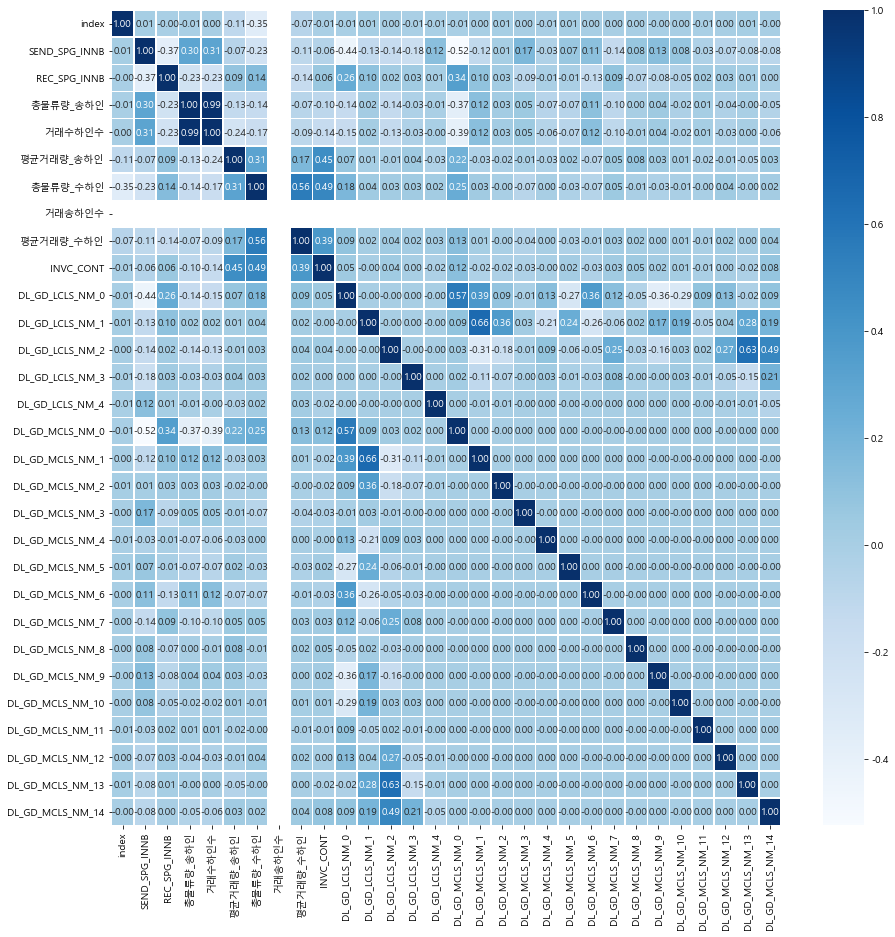

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

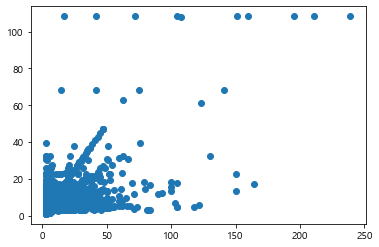

In [25]:
plt.scatter(data['INVC_CONT'], data['평균거래량'])
plt.show()

In [18]:
# 상관관계 행렬
correlationMatrix = data.corr()

In [19]:
# cutoff 기준점보다 높은 상관관계를 파악하는 함수
def high_correlated(x, cutoff):
    index_list = []
    for i in range(0, len(x)):
        for j in range(i+1, len(x)):
            if x.iloc[i][j] >= cutoff:
                index_list.append([x.columns[i], x.columns[j]])
    print(index_list)

# 함수 실행
high_correlated(correlationMatrix, 0.7)

[['총물류량', '거래수하인수']]


In [20]:
#train과 test를 분리
train = data.iloc[:32000,:]
test = data.iloc[32000:,:]
test = test.drop(columns = ['INVC_CONT']).reset_index(drop=True)

### PermutationImportance

In [21]:
X_train = train.iloc[:,1:-1]
Y_train = train.iloc[:,-1]

In [26]:
from catboost import CatBoostRegressor

In [30]:
# 검증을 위해 train_test_split
x_train, x_val, y_train, y_val =train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=42)
# 검증할 모델설정
my_model = CatBoostRegressor(verbose=0).fit(x_train, y_train)
# permutation importance 화긴
perm = PermutationImportance(my_model, random_state = 42).fit(x_val, y_val) 
eli5.show_weights(perm,top=40, feature_names = x_val.columns.tolist())

Weight,Feature
0.5196 ± 0.0360,평균거래량
0.2199 ± 0.1347,총물류량
0.0146 ± 0.0146,SEND_SPG_INNB
0.0121 ± 0.0156,DL_GD_MCLS_NM
0.0105 ± 0.0133,거래수하인수
0.0101 ± 0.0536,REC_SPG_INNB
-0.0012 ± 0.0043,DL_GD_LCLS_NM


# END